In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import mannwhitneyu
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
from rnanorm import FPKM
import warnings
import re
warnings.filterwarnings('ignore')
%matplotlib inline

In [6]:
df_rna = pd.read_csv("/storage/zhangyanxiaoLab/qihongjian/projects/transcriptome_4D/data/wanlab/nascentRNA/rna/nascentRNA_counts.txt",
                    sep='\t')
df_rna.columns = ['Geneid', 'gene', "H9D3-rep1", 'H9D3-rep2', "H9D0-rep1", 'H9D0-rep2']
df_rna = df_rna.drop_duplicates(subset='gene', keep=False)
# or
# df_rna.columns = ['Geneid', 'gene_name', "H9D0-rep1", 'H9D0-rep2', "H9D3-rep1", 'H9D3-rep2']
df_rna.corr()

,H9D3-rep1,H9D3-rep2,H9D0-rep1,H9D0-rep2
H9D3-rep1,1.000000,0.951055,0.408187,0.573067
H9D3-rep2,0.951055,1.000000,0.376889,0.648591
H9D0-rep1,0.408187,0.376889,1.000000,0.814350
H9D0-rep2,0.573067,0.648591,0.814350,1.000000


In [7]:
df_rna.head()

,Geneid,gene,H9D3-rep1,H9D3-rep2,H9D0-rep1,H9D0-rep2
0,ENSG00000223972.5,DDX11L1,8,5,9,2
1,ENSG00000227232.5,WASH7P,363,266,72,38
2,ENSG00000278267.1,MIR6859-1,16,10,8,15
3,ENSG00000243485.5,MIR1302-2HG,11,16,5,0
4,ENSG00000284332.1,MIR1302-2,0,0,0,0


In [8]:
celltype = "ESC_D3"
files = [
    f"{celltype}_ATAC_genebody.tab", f"{celltype}_ATAC_tss.tab",
    f"{celltype}_H3K27ac_genebody.tab", f"{celltype}_H3K27ac_tss.tab",
    f"{celltype}_H3K36me3_genebody.tab", f"{celltype}_H3K36me3_tss.tab",
    f"{celltype}_H3K4me1_genebody.tab", f"{celltype}_H3K4me1_tss.tab",
    f"{celltype}_H3K4me3_genebody.tab", f"{celltype}_H3K4me3_tss.tab",
    f"{celltype}_H3K9me3_genebody.tab", f"{celltype}_H3K9me3_tss.tab",
    f"{celltype}_H3K27me3_genebody.tab", f"{celltype}_H3K27me3_tss.tab"
]

# Assuming df_wan is your initial DataFrame
for file in files:
    parts = file.split('_')
    mark = parts[-2]
    #mark = '_'.join(parts[1:-1])  # e.g., H3K27ac
    region = parts[-1].split('.')[0]  # e.g., genebody or tss

    # Construct the score column name
    score_column_name = f"{mark}_{region}_mean"  # e.g., H3K27ac_genebody_mean

    # Read the file
    df_temp = pd.read_csv(f"~/projects/transcriptome_4D/data/gene_property/{file}", header=None, sep='\t',
                          names=["gene", "size", "covered", "total", "mean0", score_column_name])

    # Extract only the 'gene_full' and the score column
    df_temp = df_temp[["gene", score_column_name]]

    # Merge with df_wan
    df_rna = pd.merge(df_rna, df_temp, on="gene")
df_rna.shape

(59245, 20)

In [9]:
df_rna.head()

,Geneid,gene,H9D3-rep1,H9D3-rep2,H9D0-rep1,H9D0-rep2,ATAC_genebody_mean,ATAC_tss_mean,H3K27ac_genebody_mean,H3K27ac_tss_mean,H3K36me3_genebody_mean,H3K36me3_tss_mean,H3K4me1_genebody_mean,H3K4me1_tss_mean,H3K4me3_genebody_mean,H3K4me3_tss_mean,H3K9me3_genebody_mean,H3K9me3_tss_mean,H3K27me3_genebody_mean,H3K27me3_tss_mean
0,ENSG00000223972.5,DDX11L1,8,5,9,2,3.06997,4.58966,1.579640,1.34500,5.474900,4.00208,2.421600,1.95470,1.328120,2.179390,0.752289,0.752289,0.035055,0.445197
1,ENSG00000227232.5,WASH7P,363,266,72,38,3.33105,15.68480,3.188550,9.77416,15.999000,3.56353,4.407190,10.40910,4.228460,35.959600,0.691702,0.633512,0.374569,2.496070
2,ENSG00000278267.1,MIR6859-1,16,10,8,15,6.10226,4.35623,4.639880,3.37553,71.503600,56.16080,7.698950,6.86653,0.682924,0.546877,0.752289,0.752289,0.445197,0.178079
3,ENSG00000243485.5,MIR1302-2HG,11,16,5,0,3.13651,12.36590,1.054560,7.69324,0.753237,2.37608,3.867950,7.84436,5.546790,25.690300,0.596374,0.625645,1.423890,2.269910
4,ENSG00000284332.1,MIR1302-2,0,0,0,0,2.38154,9.76062,0.236425,6.14744,0.383346,1.66041,0.645307,6.27471,2.438810,19.335100,0.596374,0.621692,0.617427,1.985580


In [10]:
tmp = df_rna.set_index('Geneid')[['H9D0-rep1', 'H9D0-rep2', 'H9D3-rep1', 'H9D3-rep2']].transpose()
fpkm = FPKM("/storage/zhangyanxiaoLab/share/gtf/hg38.gencode.v38.annotation.gtf").set_output(transform="pandas")
df_fpkm = fpkm.fit_transform(tmp)

In [11]:
df_fpkm.head()

,ENSG00000223972.5,ENSG00000227232.5,ENSG00000278267.1,ENSG00000243485.5,ENSG00000284332.1,ENSG00000237613.2,ENSG00000268020.3,ENSG00000240361.2,ENSG00000186092.7,ENSG00000238009.6,ENSG00000239945.1,ENSG00000233750.3,ENSG00000268903.1,ENSG00000269981.1,ENSG00000239906.1,ENSG00000241860.7,ENSG00000222623.1,ENSG00000241599.1,ENSG00000279928.2,ENSG00000279457.4,ENSG00000273874.1,ENSG00000228463.10,ENSG00000286448.1,ENSG00000236679.2,ENSG00000236601.2,ENSG00000237094.12,ENSG00000269732.1,ENSG00000284733.2,ENSG00000233653.3,ENSG00000250575.1,ENSG00000230021.10,ENSG00000235146.2,ENSG00000225972.1,ENSG00000225630.1,ENSG00000237973.1,ENSG00000278791.1,ENSG00000229344.1,ENSG00000240409.1,ENSG00000248527.1,ENSG00000198744.5,ENSG00000268663.1,ENSG00000284662.1,ENSG00000229376.3,ENSG00000228327.3,ENSG00000223181.1,ENSG00000229905.1,ENSG00000237491.10,ENSG00000285268.1,ENSG00000230092.7,ENSG00000177757.2,ENSG00000228794.10,ENSG00000225880.5,ENSG00000288531.1,ENSG00000230368.2,ENSG00000234711.1,ENSG00000283040.1,ENSG00000272438.1,ENSG00000230699.2,ENSG00000241180.1,ENSG00000223764.2,ENSG00000187634.13,ENSG00000188976.11,ENSG00000187961.14,ENSG00000187583.11,ENSG00000187642.9,ENSG00000272512.1,ENSG00000188290.11,ENSG00000187608.10,ENSG00000231702.2,ENSG00000224969.1,ENSG00000188157.15,ENSG00000242590.1,ENSG00000217801.10,ENSG00000273443.1,ENSG00000237330.3,ENSG00000131591.18,ENSG00000285812.1,ENSG00000223823.1,ENSG00000207730.3,ENSG00000207607.3,ENSG00000198976.1,ENSG00000272141.1,ENSG00000205231.1,ENSG00000162571.14,ENSG00000186891.14,ENSG00000186827.11,ENSG00000078808.19,ENSG00000176022.7,ENSG00000184163.3,ENSG00000260179.1,ENSG00000160087.21,ENSG00000230415.1,ENSG00000162572.21,ENSG00000131584.19,ENSG00000278073.1,ENSG00000169972.12,ENSG00000127054.21,ENSG00000283712.1,ENSG00000240731.1,ENSG00000224051.7,ENSG00000169962.5,ENSG00000107404.20,ENSG00000284372.1,ENSG00000162576.17,ENSG00000175756.13,ENSG00000223663.2,ENSG00000221978.12,ENSG00000224870.7,ENSG00000242485.6,ENSG00000264293.2,ENSG00000272455.1,ENSG00000235098.9,ENSG00000225905.1,ENSG00000205116.4,ENSG00000225285.1,ENSG00000179403.12,ENSG00000215915.10,ENSG00000160072.20,ENSG00000284740.1,ENSG00000197785.14,ENSG00000205090.9,ENSG00000160075.12,ENSG00000215014.5,ENSG00000274481.1,ENSG00000228594.4,ENSG00000286989.1,ENSG00000272106.1,ENSG00000197530.13,ENSG00000189409.14,ENSG00000248333.9,ENSG00000272004.1,ENSG00000189339.12,ENSG00000269737.2,ENSG00000215914.4,ENSG00000008128.23,ENSG00000268575.1,ENSG00000227775.3,ENSG00000215790.8,ENSG00000008130.15,ENSG00000078369.18,ENSG00000231050.1,ENSG00000169885.10,ENSG00000178821.13,ENSG00000142609.19,ENSG00000233542.2,ENSG00000187730.9,ENSG00000226969.1,ENSG00000067606.17,ENSG00000271806.1,ENSG00000182873.5,ENSG00000162585.17,ENSG00000234396.3,ENSG00000157933.10,ENSG00000287356.1,ENSG00000116151.14,ENSG00000272161.1,ENSG00000269896.2,ENSG00000272420.1,ENSG00000157916.20,ENSG00000157911.11,ENSG00000149527.18,ENSG00000224387.1,ENSG00000229393.1,ENSG00000157881.16,ENSG00000197921.6,ENSG00000272449.2,ENSG00000238164.6,ENSG00000157873.18,ENSG00000225931.3,ENSG00000228037.1,ENSG00000157870.17,ENSG00000142606.16,ENSG00000237058.1,ENSG00000215912.12,ENSG00000285945.1,ENSG00000283259.1,ENSG00000233234.1,ENSG00000287396.1,ENSG00000231630.1,ENSG00000284745.1,ENSG00000169717.7,ENSG00000177133.12,ENSG00000142611.17,ENSG00000283572.1,ENSG00000226286.1,ENSG00000279839.1,ENSG00000272235.1,ENSG00000287828.1,ENSG00000286518.1,ENSG00000130762.15,ENSG00000272088.1,ENSG00000162591.16,ENSG00000207776.1,ENSG00000238260.1,ENSG00000158109.15,ENSG00000116213.16,ENSG00000078900.15,ENSG00000227589.1,ENSG00000235131.1,ENSG00000227372.12,ENSG00000276189.1,ENSG00000162592.10,ENSG00000235169.11,ENSG00000130764.10,ENSG00000266075.2,ENSG00000272153.1,ENSG00000116198.14,ENSG00000169598.17,ENSG00000198912.12,ENSG00000236423.6,ENSG00000233304.7,ENSG00000226374.3,ENSG00000284668.2,ENSG00000284703.1,ENSG00000229280.1,ENSG00000235054.4,ENSG00000284694.1,ENSG00000227169.2,ENSG0000

In [12]:
df_rna = pd.merge(df_rna,
                  df_fpkm.transpose().reset_index().rename(columns={"index":"Geneid",
                                                                    "H9D0-rep1": "H9D0-rep1-fpkm",
                                                                    "H9D0-rep2": "H9D0-rep2-fpkm",
                                                                    "H9D3-rep1": "H9D3-rep1-fpkm",
                                                                    "H9D3-rep2": "H9D3-rep2-fpkm"
                                                                   }), 
                  on="Geneid")

In [13]:
df_rna.head()

,Geneid,gene,H9D3-rep1,H9D3-rep2,H9D0-rep1,H9D0-rep2,ATAC_genebody_mean,ATAC_tss_mean,H3K27ac_genebody_mean,H3K27ac_tss_mean,H3K36me3_genebody_mean,H3K36me3_tss_mean,H3K4me1_genebody_mean,H3K4me1_tss_mean,H3K4me3_genebody_mean,H3K4me3_tss_mean,H3K9me3_genebody_mean,H3K9me3_tss_mean,H3K27me3_genebody_mean,H3K27me3_tss_mean,H9D0-rep1-fpkm,H9D0-rep2-fpkm,H9D3-rep1-fpkm,H9D3-rep2-fpkm
0,ENSG00000223972.5,DDX11L1,8,5,9,2,3.06997,4.58966,1.579640,1.34500,5.474900,4.00208,2.421600,1.95470,1.328120,2.179390,0.752289,0.752289,0.035055,0.445197,0.303892,0.066839,0.111953,0.065868
1,ENSG00000227232.5,WASH7P,363,266,72,38,3.33105,15.68480,3.188550,9.77416,15.999000,3.56353,4.407190,10.40910,4.228460,35.959600,0.691702,0.633512,0.374569,2.496070,3.122147,1.630902,6.523747,4.500185
2,ENSG00000278267.1,MIR6859-1,16,10,8,15,6.10226,4.35623,4.639880,3.37553,71.503600,56.16080,7.698950,6.86653,0.682924,0.546877,0.752289,0.752289,0.445197,0.178079,6.892191,12.790338,5.712904,3.361207
3,ENSG00000243485.5,MIR1302-2HG,11,16,5,0,3.13651,12.36590,1.054560,7.69324,0.753237,2.37608,3.867950,7.84436,5.546790,25.690300,0.596374,0.625645,1.423890,2.269910,0.286893,0.000000,0.261585,0.358178
4,ENSG00000284332.1,MIR1302-2,0,0,0,0,2.38154,9.76062,0.236425,6.14744,0.383346,1.66041,0.645307,6.27471,2.438810,19.335100,0.596374,0.621692,0.617427,1.985580,0.000000,0.000000,0.000000,0.000000


/storage/zhangyanxiaoLab/qihongjian/github/zhanglab-code/projects/transcriptome_4D/code/version5


In [17]:
# plot tracing only genes
df_trace = pd.read_csv("genes/combined-gene-on-off.csv")
df_trace_gene = set(df_trace['gene'])

(67, 24)


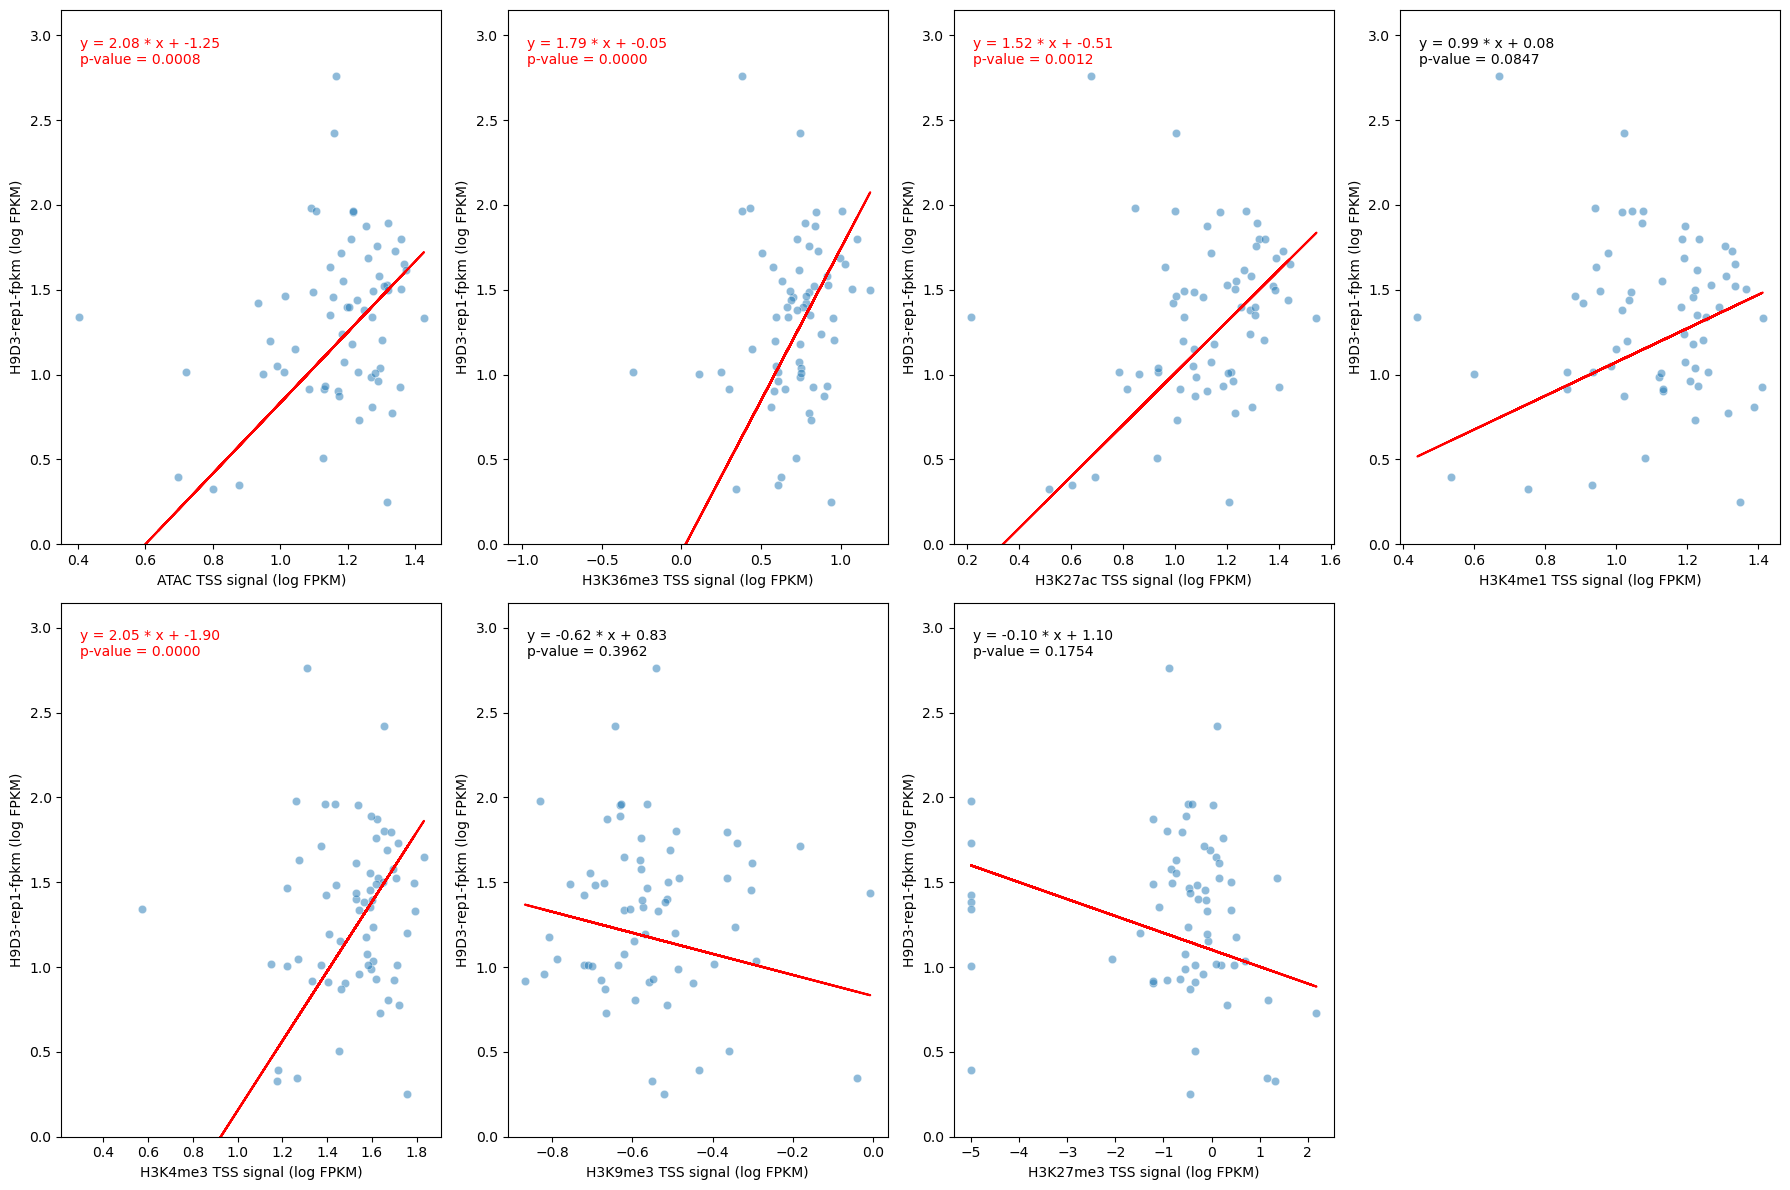

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np


data = df_rna[(df_rna["H9D3-rep1-fpkm"] > 1) & (df_rna["H9D3-rep1-fpkm"] < 20_000)]
data = df_rna[df_rna.gene.isin(df_trace_gene)]
print(data.shape)


columns = [
    'ATAC_tss_mean',
    'H3K36me3_tss_mean',
    'H3K27ac_tss_mean',
    'H3K4me1_tss_mean',
    'H3K4me3_tss_mean',
    'H3K9me3_tss_mean',
    'H3K27me3_tss_mean',
]

plt.figure(figsize=(18, 12))

for i, col in enumerate(columns):
    y_col = 'H9D3-rep1-fpkm'
    x_col = col

    ax = plt.subplot(2, 4, i + 1)

    # Apply log transformation
    x = np.log10(data[x_col]+0.00001)
    y = np.log10(data[y_col]+0.00001)

    # Plot the data
    sns.scatterplot(ax=ax, x=x, y=y, sizes=(10, 200), alpha=0.5, marker='o')
    

    X = sm.add_constant(x)

    model = sm.OLS(y, X).fit()


    m = model.params[1]
    b = model.params[0]
    p = model.pvalues[1]
    ax.plot(x, m*x + b, color='red')

    if p < 0.05:
        color = "red"
    else:
        color = "black"
        
    ax.text(0.05, 0.95, f'y = {m:.2f} * x + {b:.2f}\np-value = {p:.4f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top', color=color)

    ax.set_xlabel(f'{x_col.replace("_", " ").replace("mean", "signal").replace("tss", "TSS")} (log FPKM)')
    ax.set_ylabel(f'{y_col} (log FPKM)')
    #ax.set_title(f'{y_col} vs {x_col}')
    ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()


In [33]:
# data = df_rna[(df_rna["H9D3-rep1-fpkm"] > 1) & (df_rna["H9D3-rep1-fpkm"] < 20_000)]


# print(data.shape)

# # Define the columns for plotting
# columns = ['ATAC_tss_mean',
#            'H3K36me3_tss_mean',
#            'H3K27ac_tss_mean',
#            'H3K4me1_tss_mean',
#            'H3K4me3_tss_mean', 
#            'H3K9me3_tss_mean',
#            'H3K27me3_tss_mean',
#           ]

# plt.figure(figsize=(18, 12))

# for i, col in enumerate(columns):
#     y_col = 'H9D3-rep1-fpkm' #'off-median' #'off-mean' # 'K-on-rate'
#     x_col = col

#     ax = plt.subplot(2, 4, i + 1)
#     sns.scatterplot(ax=ax, data=data, x=x_col, y=y_col, sizes=(10, 200), alpha=0.5, marker='o')
    
#     #sns.kdeplot(ax=ax, data=data, x=x_col, y=y_col, fill=True, cmap='viridis')

    
    
#     # Prepare data for weighted regression
#     x = data[x_col]
#     y = data[y_col] #.dropna()  # Drop NaN values
#     X = sm.add_constant(x)
    

#     # 拟合普通最小二乘法（OLS）模型
#     model = sm.OLS(y, X).fit()


#     # Plot regression line
#     m = model.params[1]
#     b = model.params[0]
#     p = model.pvalues[1]
#     ax.plot(x, m*x + b, color='red')
#     #ax.set_yscale('log')
#     #ax.set_xscale('log')

#     # Annotate with regression equation and p-value
#     ax.text(0.05, 0.95, f'y = {m:.2f}x + {b:.2f}\np-value = {p:.4f}', 
#             transform=ax.transAxes, fontsize=10, verticalalignment='top', color='red')

#     ax.set_xlabel(x_col)
#     ax.set_ylabel(y_col)
#     ax.set_title(f'{y_col} vs {x_col}')


# plt.tight_layout()
# plt.show()


(67, 24)


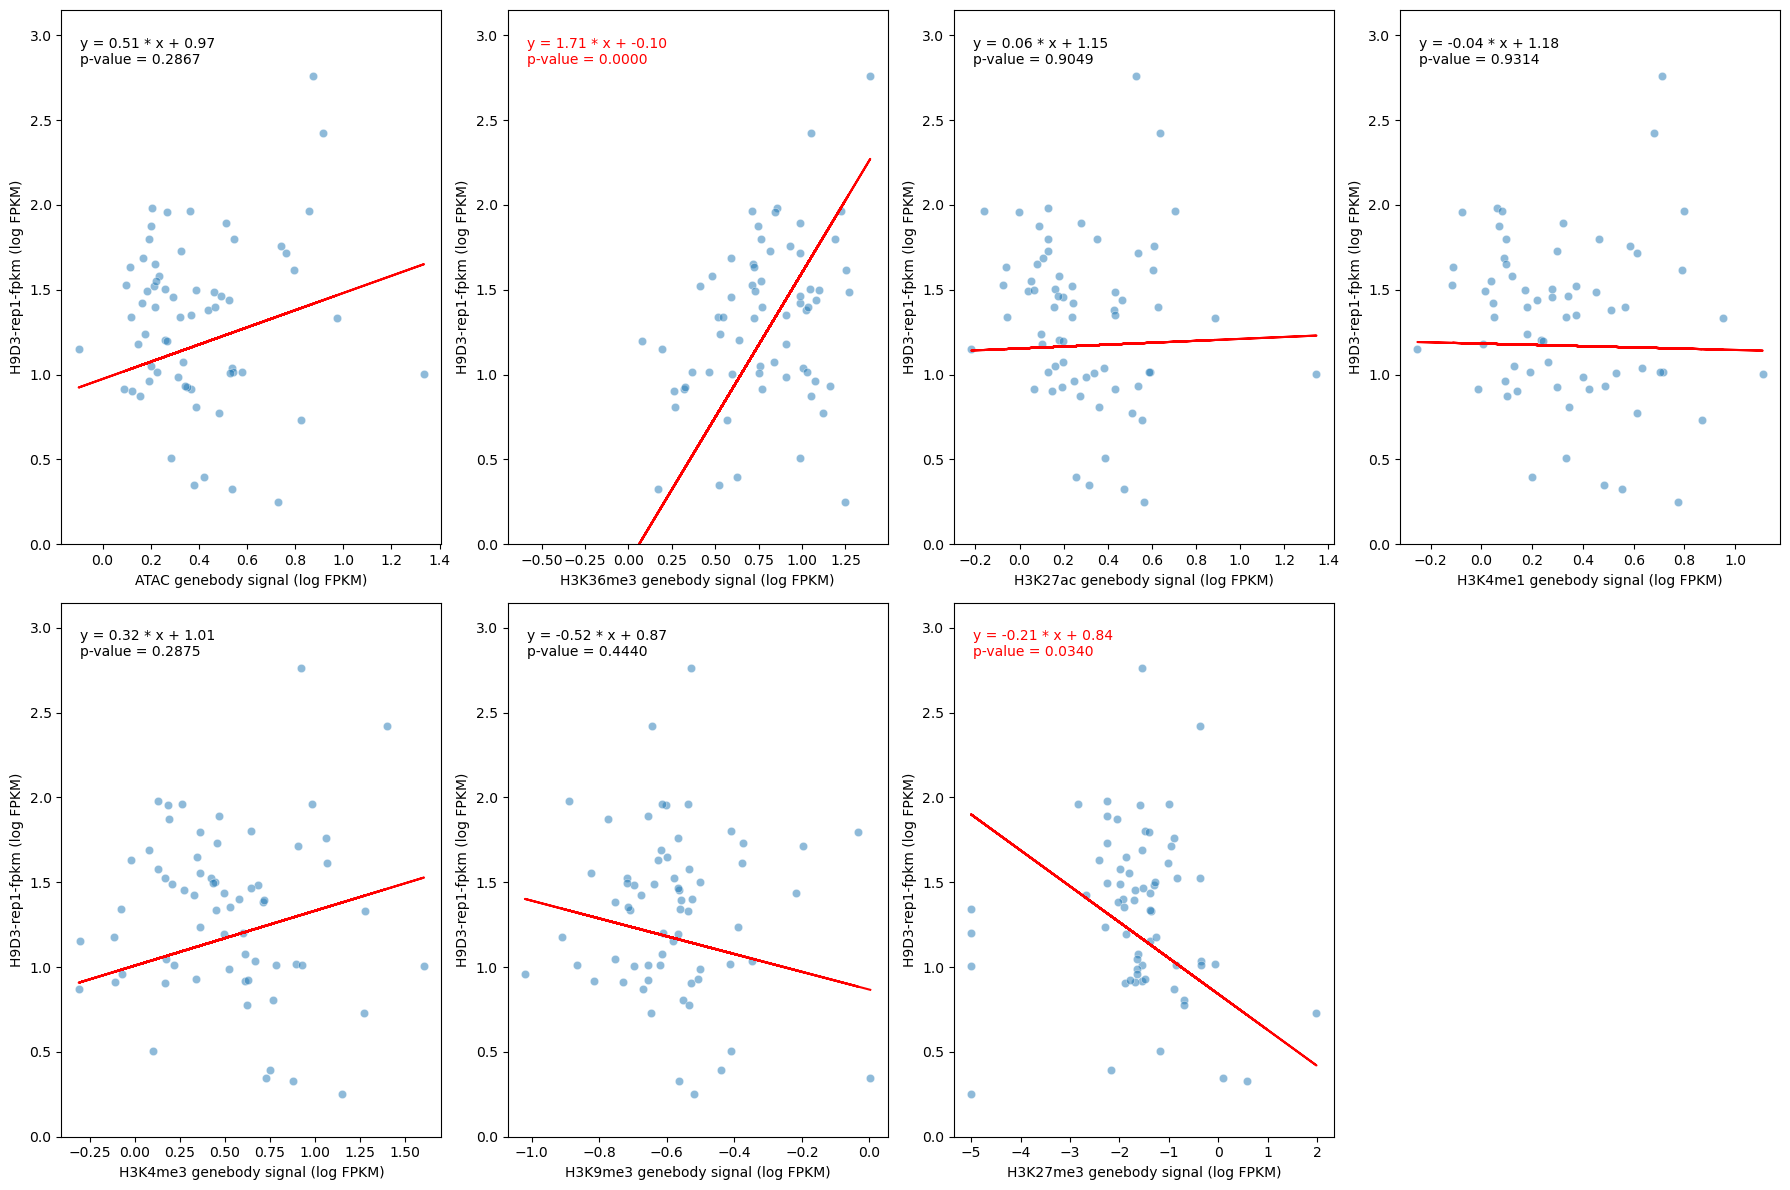

In [34]:
data = df_rna[(df_rna["H9D3-rep1-fpkm"] > 1) & (df_rna["H9D3-rep1-fpkm"] < 20_000)]
data = df_rna[df_rna.gene.isin(df_trace_gene)]
print(data.shape)


columns = ['ATAC_genebody_mean',
           'H3K36me3_genebody_mean',
           
           'H3K27ac_genebody_mean',
           'H3K4me1_genebody_mean',
           'H3K4me3_genebody_mean', 
           'H3K9me3_genebody_mean',
           'H3K27me3_genebody_mean',
          ]

plt.figure(figsize=(18, 12))

for i, col in enumerate(columns):
    y_col = 'H9D3-rep1-fpkm'
    x_col = col

    ax = plt.subplot(2, 4, i + 1)

    # Apply log transformation
    x = np.log10(data[x_col]+0.00001)
    y = np.log10(data[y_col]+0.00001)

    # Plot the data
    sns.scatterplot(ax=ax, x=x, y=y, sizes=(10, 200), alpha=0.5, marker='o')
    

    X = sm.add_constant(x)

    model = sm.OLS(y, X).fit()


    m = model.params[1]
    b = model.params[0]
    p = model.pvalues[1]
    ax.plot(x, m*x + b, color='red')

    if p < 0.05:
        color = "red"
    else:
        color = "black"
        
    ax.text(0.05, 0.95, f'y = {m:.2f} * x + {b:.2f}\np-value = {p:.4f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top', color=color)

    ax.set_xlabel(f'{x_col.replace("_", " ").replace("mean", "signal").replace("tss", "TSS")} (log FPKM)')
    ax.set_ylabel(f'{y_col} (log FPKM)')
    #ax.set_title(f'{y_col} vs {x_col}')
    ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()
